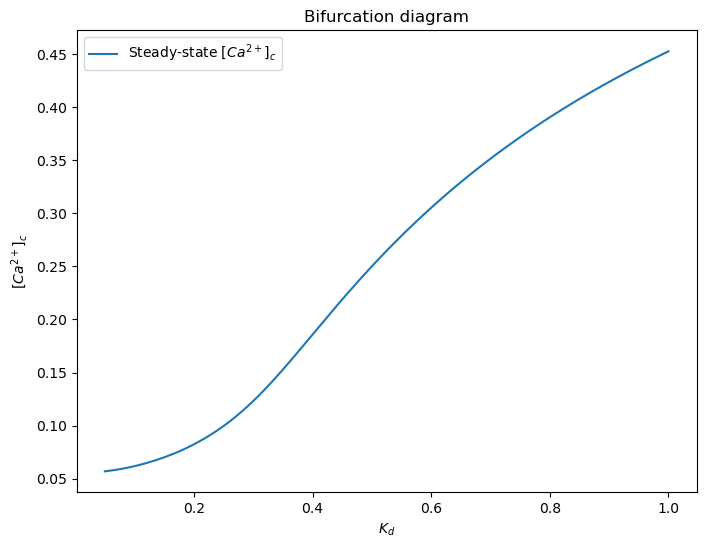

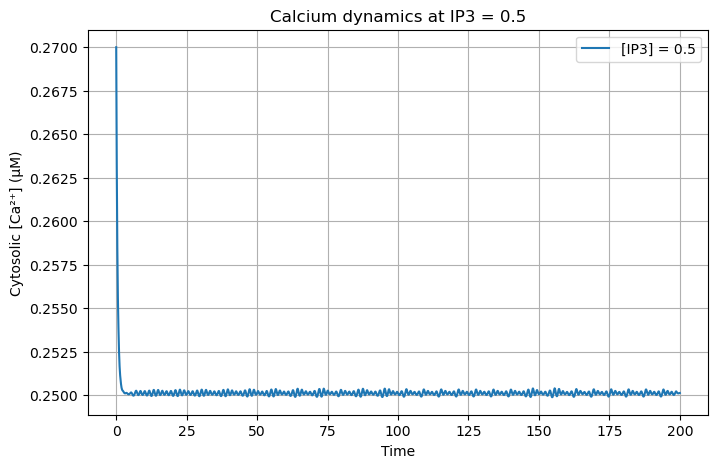

In [12]:

import numpy as np
from scipy.integrate import solve_ivp
from numpy.linalg import eigvals
import matplotlib.pyplot as plt
from scipy.optimize import root


CO = 2.0       
c1 = 0.185     
v1 = 6.0       
v2 = 0.11      
v3 = 0.9        
k3 = 0.1       

# receptor binding constants
a1 = 400.0
a2 = 0.2
a3 = 400.0
a4 = 0.2
a5 = 20.0

d1 = 0.13      
d2 = 1.049     
d3 = 0.9434    
d4 = 0.1445   
d5 = 0.08234   


# -------------------------------------------------------------------------

def P_open(C, IP3):
    """

    """
    numerator = C * IP3 * d2
    denominator = (C * IP3 + IP3 * d2 + d1*d2 + C*d3)*(C + d5)
   
    return (numerator/denominator)**3

def J1(C, CaER, IP3):
    return c1 * (v1 * P_open(C, IP3) + v2) * (CaER - C)

def J2(C):
    return v3 * (C**2) / (C**2 + k3**2)

def rhs(t, y, IP3):
    C = y[0]
    CaER = (CO - C) / c1
    dCdt = J1(C, CaER, IP3) - J2(C)
    return [dCdt]



IP3_vals = np.linspace(0.05, 1.0, 200)   # µM, dense enough to capture the Hopf region (~0.37-0.62)
steady_C = np.zeros_like(IP3_vals)
stability = np.zeros_like(IP3_vals, dtype=int)  # 1 stable, -1 unstable
osc_min = np.full_like(IP3_vals, np.nan)
osc_max = np.full_like(IP3_vals, np.nan)

y0 = [0.05]
steady_states = []

for Kd in IP3_vals:
    def ss_func(Y): 
        return rhs(0, Y, Kd)

        
    res = root(ss_func, y0, method='hybr')
    if not res.success: 
        continue
    c_star = res.x[0]       # extract scalar
    steady_states.append((Kd, c_star))
    y0 = res.x

   
plt.figure(figsize=(8,6))

steady_states = np.array(steady_states)
plt.plot(steady_states[:,0], steady_states[:,1], label='Steady-state $[Ca^{2+}]_c$')
plt.xlabel('$K_d$')
plt.ylabel('$[Ca^{2+}]_c$')
plt.legend()
plt.title("Bifurcation diagram")
plt.savefig("bifurcation_diagram.pdf")
plt.show()

IP3_test = 0.5  
y0 = [0.27]  
t_span = (0, 200)   # seconds (or arbitrary units)
t_eval = np.linspace(*t_span, 2000)

sol = solve_ivp(rhs, t_span, y0, args=(IP3_test,), t_eval=t_eval, method='RK45')

# plot time course
plt.figure(figsize=(8,5))
plt.plot(sol.t, sol.y[0], label=f'[IP3] = {IP3_test}')
plt.xlabel('Time')
plt.ylabel('Cytosolic [Ca²⁺] (µM)')
plt.title('Calcium dynamics at IP3 = 0.5')
plt.legend()
plt.grid(True)
plt.show()



# plt.plot(IP3_vals, steady_C, 'k-', label='steady state')

# plt.xlabel('[IP3] (µM)')
# plt.ylabel('cytosolic [Ca2+] (µM)')
# plt.title('Bifurcation diagram (D-Y-K model)')
# plt.ylim(-0.02, 1.2)
# plt.xlim(IP3_vals[0], IP3_vals[-1])
# plt.legend(loc='best')
# plt.grid(True)
# plt.show()
